 ## Make a plot of the prediction accuracy for a range of inputs for min_samples_leaf for a range of different sized test vs train set ratios (on the NYC taxi dataset). What is the best input value, and why do you think this is best? How does the best value depend on the size of the train and/or test set? How does min_samples_leaf compare to min_samples_split?


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

my_path = my_path = '/content/drive/My Drive/train.csv'
train = pd.read_csv(my_path, parse_dates =['pickup_datetime'])
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
y_train = pd.DataFrame(train.loc[:,'trip_duration'])
y_train

,trip_duration
0,455
1,663
2,2124
3,429
4,435
...,...
1458639,778
1458640,655
1458641,764
1458642,373


In [ ]:
from datetime import datetime 
from datetime import date

train['year'] = train['pickup_datetime'].dt.year
train['month'] = train['pickup_datetime'].dt.month
train['day'] = train['pickup_datetime'].dt.day
train['hr'] = train['pickup_datetime'].dt.hour
train['minute'] = train['pickup_datetime'].dt.minute
# convert to dummy
train.loc[train['store_and_fwd_flag'] == 'Y','store_and_fwd_flag'] = 1
train.loc[train['store_and_fwd_flag'] == 'N','store_and_fwd_flag'] = 0

In [ ]:
my_path = '/content/drive/My Drive/NYC_2016Holidays.csv'
holiday = pd.read_csv(my_path, sep = ';') 
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')
holiday.head()

,Day,Date,Holiday
0,Friday,January 01 2016,New Years Day
1,Monday,January 18 2016,Martin Luther King Jr. Day
2,Friday,February 12 2016,Lincoln's Birthday
3,Monday,February 15 2016,Presidents' Day
4,Sunday,May 08 2016,Mother's Day


In [ ]:
special_days = pd.DataFrame(index = range(len(train)))  

In [ ]:
def find_holiday(yr, month, day, holidays):
    holiday =  [None]*len(yr)
    weekend =  [None]*len(yr)
    i = 0 
    for yy,mm,dd in zip(yr, month, day):
        weekend[i] = date(yy,mm,dd).isoweekday() in (6,7)
        holiday[i] = weekend[i] or date(yy,mm,dd)  in holidays
        i+=1
    return holiday, weekend

In [ ]:
holiday,weekend = find_holiday(train.year, train.month, train.day, holiday)
special_days = special_days.assign(holiday = holiday)
special_days = special_days.assign(weekend = weekend)

print(special_days.dtypes)
#my_tab = pd.crosstab(index=special_days['holiday'],columns="count") 
#my_tab
special_days.info()

holiday    bool
weekend    bool
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   holiday  1458644 non-null  bool 
 1   weekend  1458644 non-null  bool 
dtypes: bool(2)
memory usage: 2.8 MB


In [ ]:
from sklearn.cluster import MiniBatchKMeans

coord_pickup = np.vstack(train[['pickup_latitude', 'pickup_longitude']].values)
coord_dropoff = np.vstack(train[['dropoff_latitude', 'dropoff_longitude']].values)

# get random start points
coords = np.hstack((coord_pickup,coord_dropoff))
sample_ind = np.random.permutation(len(coords))[:500000]


kmeans = MiniBatchKMeans(n_clusters=10, batch_size =10000).fit(coords[sample_ind])
train.loc[:,'pickup_dropoff_loc'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude','dropoff_latitude','dropoff_longitude']])
train.loc[:,'pickup_dropoff_loc'].head()
# note that these were the levels in the original df
my_tab = pd.crosstab(index=train['pickup_dropoff_loc'],columns="count") 
my_tab

col_0,count
pickup_dropoff_loc,
0,502955
1,124127
2,32635
3,59590
4,266358
5,358176
6,14659
7,36386
8,24245


In [ ]:
y_train.head()

,trip_duration
0,455
1,663
2,2124
3,429
4,435


In [ ]:
y_train.shape

(1458644, 1)

In [ ]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,day,hr,minute,pickup_dropoff_loc
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,2016,3,14,17,24,4
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,2016,6,12,0,43,5
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,2016,1,19,11,35,5
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,2016,4,6,19,32,5
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,2016,3,26,13,30,1


In [ ]:
train.shape

(1458644, 17)

In [ ]:
train = train[['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_dropoff_loc','store_and_fwd_flag']]
train  = pd.concat([train ,special_days],axis=1)
train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_dropoff_loc,store_and_fwd_flag,holiday,weekend
0,2,1,-73.982155,40.767937,-73.964630,40.765602,4,0,False,False
1,1,1,-73.980415,40.738564,-73.999481,40.731152,5,0,True,True
2,2,1,-73.979027,40.763939,-74.005333,40.710087,5,0,False,False
3,2,1,-74.010040,40.719971,-74.012268,40.706718,5,0,False,False
4,2,1,-73.973053,40.793209,-73.972923,40.782520,1,0,True,True


In [ ]:
train.shape

(1458644, 10)

Find overall loss:

In [ ]:
def findOverallLoss(ypreds,Y):
  err = abs(ypreds.reset_index(drop=True).T - Y.reset_index(drop=True).values.squeeze())
  MAPE = err.mean(axis=1)
  return MAPE

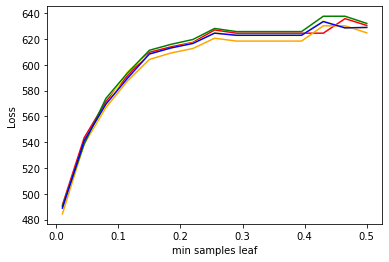

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import tree
min_samples = np.linspace(0.01, 0.5, 15, endpoint=True)

x_train1, x_test1, y_train1, y_test1 = train_test_split(train,y_train, test_size=0.1)  # split with given ratio
all1 = pd.DataFrame()     # generate empty matrix
for min_sample in min_samples:   # and for each of the min_samples option
   clf = tree.DecisionTreeRegressor(min_samples_leaf=min_sample)   # generate a tree with that many samples
   clf = clf.fit(x_train1, y_train1)   # fit the tree with the train x annd y
   y_pred = clf.predict(x_test1)   # generate predictions for the test x
   loss = findOverallLoss(pd.DataFrame(y_pred),pd.DataFrame(y_test1))  # find the loss of the prediction compared to the real test y values 
   row = pd.DataFrame(loss).T
   all1 = [all1, row]
   all1 = pd.concat(all1,axis=0,ignore_index=True)   # make a matrix with the minimum samples per leaf and the loss it gave 
   
x_train2, x_test2, y_train2, y_test2 = train_test_split(train,y_train, test_size=0.2)
all2 = pd.DataFrame()
for min_sample in min_samples:
   clf = tree.DecisionTreeRegressor(min_samples_leaf=min_sample)
   clf = clf.fit(x_train2, y_train2)
   y_pred = clf.predict(x_test2)
   loss = findOverallLoss(pd.DataFrame(y_pred),pd.DataFrame(y_test2))
   row = pd.DataFrame(loss).T
   all2 = [all2, row]
   all2 = pd.concat(all2,axis=0,ignore_index=True)

x_train3, x_test3, y_train3, y_test3 = train_test_split(train,y_train, test_size=0.3)
all3 = pd.DataFrame()
for min_sample in min_samples:
   clf = tree.DecisionTreeRegressor(min_samples_leaf=min_sample)
   clf = clf.fit(x_train3, y_train3)
   y_pred = clf.predict(x_test3)
   loss = findOverallLoss(pd.DataFrame(y_pred),pd.DataFrame(y_test3))
   row = pd.DataFrame(loss).T
   all3 = [all3, row]
   all3 = pd.concat(all3,axis=0,ignore_index=True)

x_train4, x_test4, y_train4, y_test4 = train_test_split(train,y_train, test_size=0.4)
all4 = pd.DataFrame()
for min_sample in min_samples:
   clf = tree.DecisionTreeRegressor(min_samples_leaf=min_sample)
   clf = clf.fit(x_train4, y_train4)
   y_pred = clf.predict(x_test4)
   loss = findOverallLoss(pd.DataFrame(y_pred),pd.DataFrame(y_test4))
   row = pd.DataFrame(loss).T
   all4 = [all4, row]
   all4 = pd.concat(all4,axis=0,ignore_index=True)

x_train5, x_test5, y_train5, y_test5 = train_test_split(train,y_train, test_size=0.5)
all5 = pd.DataFrame()
for min_sample in min_samples:
   clf = tree.DecisionTreeRegressor(min_samples_leaf=min_sample)
   clf = clf.fit(x_train5, y_train5)
   y_pred = clf.predict(x_test5)
   loss = findOverallLoss(pd.DataFrame(y_pred),pd.DataFrame(y_test5))
   row = pd.DataFrame(loss).T
   all5 = [all5, row]
   all5 = pd.concat(all5,axis=0,ignore_index=True)



# plot where min_samples is on the x and the loss given the min_samples for a given train/test ratio is on the y
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
plt.plot(min_samples, all1,  label="Loss", color = "red") # 0.1
plt.plot(min_samples, all2,  label="Loss", color = "orange") # 0.2
plt.plot(min_samples, all3,  label="Loss", color = "yellow") # 0.3
plt.plot(min_samples, all4,  label="Loss", color = "green") # 0.4
plt.plot(min_samples, all5,  label="Loss", color = "blue") # 0.5
plt.ylabel('Loss')
plt.xlabel('min samples leaf')
plt.show()
  